In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/passengers-data/airline-passengers.csv


## Урок 5. Рекуррентные нейронные сети

### Домашнее задание:

1. Попробуйте изменить параметры нейронной сети работающей с датасетом imdb либо нейронной сети работающей airline-passengers(она прилагается вместе с датасетом к уроку в виде отдельного скрипта) так, чтобы улучшить ее точность. Приложите анализ.
2. Попробуйте изменить параметры нейронной сети генерирующий текст таким образом, чтобы добиться генерации как можно более осмысленного текста. Пришлите лучший получившейся у вас текст и опишите, что вы предприняли, чтобы его получить. Можно использовать текст другого прозведения.

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv1D, Flatten
from keras.layers import SimpleRNN, LSTM, SimpleRNNCell, GRU

In [3]:
tf.config.list_physical_devices('GPU')

2023-01-11 11:50:50.128690: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-11 11:50:50.129691: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-11 11:50:50.261388: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-11 11:50:50.262367: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-11 11:50:50.263181: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [4]:
airline_passengers_data = pd.read_csv('/kaggle/input/passengers-data/airline-passengers.csv')

In [5]:
airline_passengers_data.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [6]:
airline_passengers_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Month       144 non-null    object
 1   Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [7]:
airline_passengers_data['Month'].value_counts()

1949-01    1
1949-02    1
1956-09    1
1956-10    1
1956-11    1
          ..
1953-01    1
1953-02    1
1953-03    1
1953-04    1
1960-12    1
Name: Month, Length: 144, dtype: int64

парсим данные:

In [8]:
airline_passengers_data['Month'] = pd.to_datetime(airline_passengers_data['Month'], format='%Y-%m')

In [9]:
def parse_date(df, date_feature_name):
    date_list = df[date_feature_name]
    years = []
    months = []
    for el in date_list:
        years.append(el.year)
        months.append(el.month)
    df['year'] = years
    df['mon'] = months

    return df

In [10]:
airline_passengers_data = parse_date(airline_passengers_data, 'Month')

отбросим столбец №1 т.к. признаки [year,mon] его представляют

In [11]:
data = airline_passengers_data.iloc[:, 1:]
data.head()

,Passengers,year,mon
0,112,1949,1
1,118,1949,2
2,132,1949,3
3,129,1949,4
4,121,1949,5


Производим разбивку выборки на обучение и тест:

In [12]:
train_size = 100


# список признаков, по которым будем учить
features = ['Passengers', 'year', 'mon']


# отступ теста от тренировки
bias = 5


# делим
train_data = data.iloc[:train_size][features]
val_data = data.iloc[train_size + bias:][features]

train_data.shape, val_data.shape

((100, 3), (39, 3))

Генерируем данные для обучения:

In [13]:
features = train_data.columns[1:]
target = train_data.columns[0]

In [14]:
scaler = StandardScaler()

train_data[features] = scaler.fit_transform(train_data[features])
val_data[features] = scaler.transform(val_data[features])

train_data.head()

,Passengers,year,mon
0,112,-1.525724,-1.534863
1,118,-1.525724,-1.247435
2,132,-1.525724,-0.960008
3,129,-1.525724,-0.672580
4,121,-1.525724,-0.385153


Формируем параметры для генерации выборки:

In [15]:
# длина истории
x_len = 3

# горизонт предсказания
future = 1

# параметры модели для обучения
learning_rate = 0.001
batch_size = 8
epochs = 10

In [16]:
start = x_len + future
end = start + train_size

print(start, end)

X_train = train_data[features].values
y_train = data.iloc[start:end][target].values


x_end = len(val_data) - x_len - future
label_start = len(train_data) + bias + x_len + future
print(x_end, label_start)

X_val = val_data.iloc[:x_end][features].values
y_val = data.iloc[label_start:][target].values

4 104
35 109


In [17]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((100, 2), (100,), (35, 2), (35,))

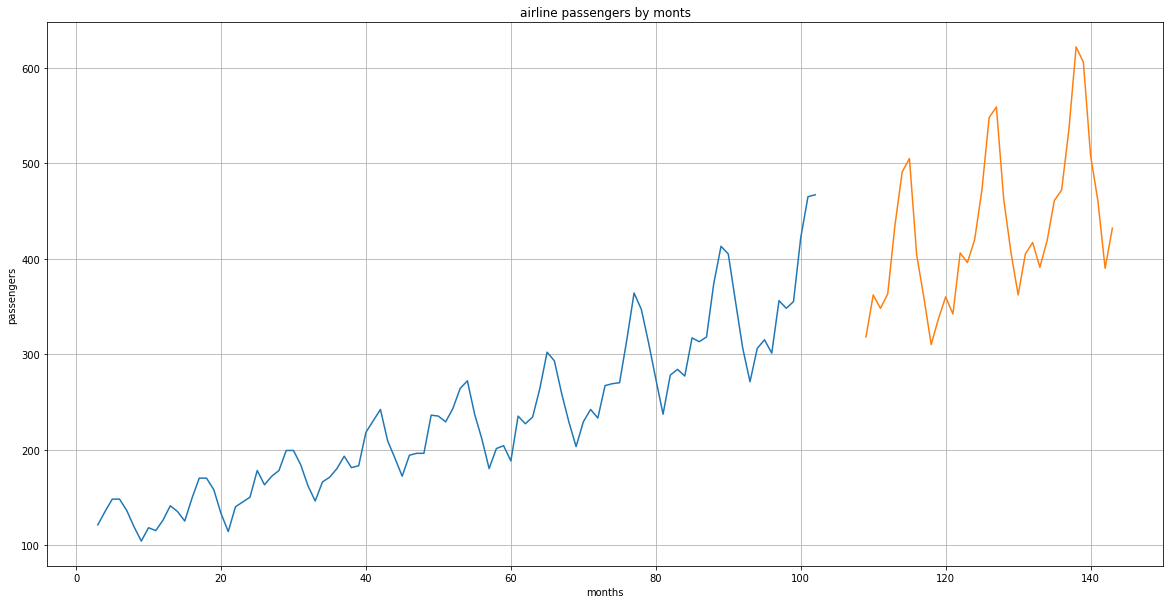

In [18]:
plt.figure(figsize=(20, 10))
plt.plot(data.index[x_len:y_train.shape[0]+x_len],y_train[:])
plt.plot(data.index[y_train.shape[0]+x_len+bias+future:],y_val[:])
plt.grid('on')
plt.xlabel('months')
plt.ylabel('passengers')
plt.title('airline passengers by monts')
plt.show()

In [19]:
dataset_train = timeseries_dataset_from_array(
    X_train,
    y_train,
    sequence_length=x_len,
    sampling_rate=1,
    batch_size=batch_size,
)

dataset_val = timeseries_dataset_from_array(
    X_val,
    y_val,
    sequence_length=x_len,
    sampling_rate=1,
    batch_size=batch_size,
)

2023-01-11 11:50:51.390593: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-11 11:50:51.652788: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-11 11:50:51.653788: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-11 11:50:51.654612: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

In [20]:
for batch in dataset_train.take(1):
    inputs, targets = batch
    print("Input shape:", inputs.shape)
    print(inputs[1])
    print("Target shape:", targets.shape)
    print(targets[1])

Input shape: (8, 3, 2)
tf.Tensor(
[[-1.52572369 -1.24743549]
 [-1.52572369 -0.96000796]
 [-1.52572369 -0.67258043]], shape=(3, 2), dtype=float64)
Target shape: (8,)
tf.Tensor(135, shape=(), dtype=int64)


2023-01-11 11:50:55.133696: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [21]:
results = pd.DataFrame() # сводная таблица результатов
model = [] # шаг
train_m = [] # результат на трейне
test_m = [] # результат на тесте

### SimpleRNN

In [22]:
early_stop = EarlyStopping(monitor='val_mae', patience=5)

model_1 = Sequential()

model_1.add(SimpleRNN(32, input_shape=(inputs.shape[1], inputs.shape[2]),
               return_sequences=True))
model_1.add(Conv1D(64, 3, activation='linear'))
model_1.add(Conv1D(64, 1, activation='linear'))
model_1.add(Flatten())
model_1.add(Dense(3, activation='linear'))
model_1.add(Dense(1, activation='linear'))

model_1.compile(loss='mse', optimizer='adam', metrics=['mae'])
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 3, 32)             1120      
_________________________________________________________________
conv1d (Conv1D)              (None, 1, 64)             6208      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1, 64)             4160      
_________________________________________________________________
flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 3)                 195       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 4         
Total params: 11,687
Trainable params: 11,687
Non-trainable params: 0
____________________________________________________

In [23]:
history_1 = model_1.fit(dataset_train,
                    epochs=epochs,
                    validation_data=dataset_val,
                    callbacks=[early_stop])

Epoch 1/10


2023-01-11 11:50:58.960274: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


13/13 [==============================] - 10s 41ms/step - loss: 57367.8789 - mae: 226.5492 - val_loss: 197164.1250 - val_mae: 436.7626
Epoch 2/10
13/13 [==============================] - 0s 13ms/step - loss: 56542.8359 - mae: 224.8458 - val_loss: 194254.7656 - val_mae: 433.4689
Epoch 3/10
13/13 [==============================] - 0s 13ms/step - loss: 56273.4727 - mae: 224.6896 - val_loss: 191892.9844 - val_mae: 430.7888
Epoch 4/10
13/13 [==============================] - 0s 14ms/step - loss: 55893.1367 - mae: 224.2755 - val_loss: 188731.5781 - val_mae: 427.1920
Epoch 5/10
13/13 [==============================] - 0s 14ms/step - loss: 55120.3359 - mae: 223.2391 - val_loss: 182884.5781 - val_mae: 420.4670
Epoch 6/10
13/13 [==============================] - 0s 14ms/step - loss: 53368.6133 - mae: 220.6385 - val_loss: 170978.2656 - val_mae: 406.4088
Epoch 7/10
13/13 [==============================] - 0s 13ms/step - loss: 49374.2656 - mae: 214.0086 - val_loss: 147219.4062 - val_mae: 376.6884
Ep

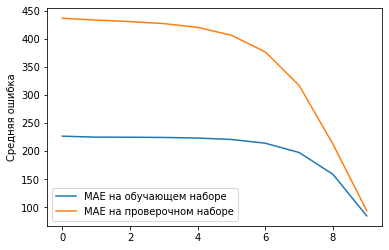

In [24]:
plt.plot(history_1.history['mae'][:], 
         label='MAE на обучающем наборе')
plt.plot(history_1.history['val_mae'][:], 
         label='MAE на проверочном наборе')

plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [25]:
hist_val_1 = history_1.history['val_mae']
hist_train_1 = history_1.history['mae']

In [26]:
num_iterations = 25

Epoch 1/10
13/13 [==============================] - 0s 14ms/step - loss: 4303.5630 - mae: 54.0569 - val_loss: 10293.7598 - val_mae: 82.8277
Epoch 2/10
13/13 [==============================] - 0s 13ms/step - loss: 1675.2516 - mae: 32.5674 - val_loss: 18825.6172 - val_mae: 120.0184
Epoch 3/10
13/13 [==============================] - 0s 13ms/step - loss: 1244.1271 - mae: 27.2853 - val_loss: 14916.6084 - val_mae: 104.0929
Epoch 4/10
13/13 [==============================] - 0s 13ms/step - loss: 1267.7087 - mae: 27.8780 - val_loss: 12508.8652 - val_mae: 93.4696
Epoch 5/10
13/13 [==============================] - 0s 13ms/step - loss: 1208.5863 - mae: 27.7760 - val_loss: 13086.3740 - val_mae: 96.6595
Epoch 6/10
13/13 [==============================] - 0s 13ms/step - loss: 1140.2731 - mae: 26.9596 - val_loss: 12747.6221 - val_mae: 95.3578
Epoch 1/10
13/13 [==============================] - 0s 14ms/step - loss: 1097.2081 - mae: 26.3106 - val_loss: 12206.2471 - val_mae: 92.9542
Epoch 2/10
13/13 [

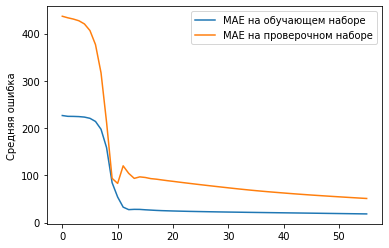

Epoch 1/10
13/13 [==============================] - 0s 16ms/step - loss: 529.2859 - mae: 18.0713 - val_loss: 4309.1235 - val_mae: 50.2332
Epoch 2/10
13/13 [==============================] - 0s 15ms/step - loss: 521.9620 - mae: 17.9215 - val_loss: 4220.5073 - val_mae: 49.5663
Epoch 3/10
13/13 [==============================] - 0s 15ms/step - loss: 514.6323 - mae: 17.7676 - val_loss: 4134.7720 - val_mae: 48.9065
Epoch 4/10
13/13 [==============================] - 0s 13ms/step - loss: 507.2689 - mae: 17.6101 - val_loss: 4051.6663 - val_mae: 48.2760
Epoch 5/10
13/13 [==============================] - 0s 14ms/step - loss: 499.8437 - mae: 17.4498 - val_loss: 3970.9292 - val_mae: 47.7000
Epoch 6/10
13/13 [==============================] - 0s 13ms/step - loss: 492.3266 - mae: 17.2859 - val_loss: 3892.3091 - val_mae: 47.1275
Epoch 7/10
13/13 [==============================] - 0s 14ms/step - loss: 484.6895 - mae: 17.1256 - val_loss: 3815.5549 - val_mae: 46.5574
Epoch 8/10
13/13 [================

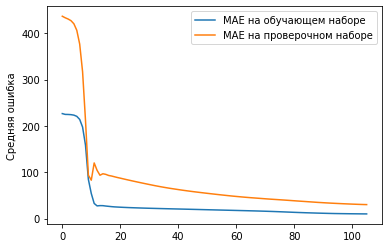

Epoch 1/10
13/13 [==============================] - 0s 13ms/step - loss: 157.9948 - mae: 9.9001 - val_loss: 1521.7759 - val_mae: 29.9286
Epoch 2/10
13/13 [==============================] - 0s 16ms/step - loss: 156.4464 - mae: 9.8456 - val_loss: 1504.5763 - val_mae: 29.7942
Epoch 3/10
13/13 [==============================] - 0s 12ms/step - loss: 154.9446 - mae: 9.7988 - val_loss: 1488.3208 - val_mae: 29.6638
Epoch 4/10
13/13 [==============================] - 0s 12ms/step - loss: 153.5685 - mae: 9.7548 - val_loss: 1473.5892 - val_mae: 29.5583
Epoch 5/10
13/13 [==============================] - 0s 13ms/step - loss: 152.1592 - mae: 9.7161 - val_loss: 1459.3776 - val_mae: 29.4616
Epoch 6/10
13/13 [==============================] - 0s 13ms/step - loss: 150.9476 - mae: 9.6785 - val_loss: 1446.8956 - val_mae: 29.3768
Epoch 7/10
13/13 [==============================] - 0s 13ms/step - loss: 149.5417 - mae: 9.6481 - val_loss: 1434.2598 - val_mae: 29.3329
Epoch 8/10
13/13 [=======================

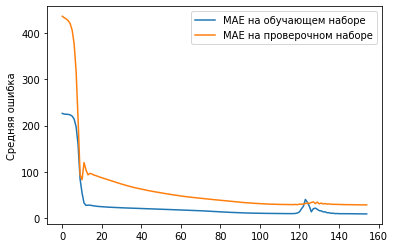

Epoch 1/10
13/13 [==============================] - 0s 13ms/step - loss: 125.9678 - mae: 8.9202 - val_loss: 1292.1370 - val_mae: 28.3302
Epoch 2/10
13/13 [==============================] - 0s 13ms/step - loss: 125.0518 - mae: 8.8661 - val_loss: 1287.2144 - val_mae: 28.3288
Epoch 3/10
13/13 [==============================] - 0s 13ms/step - loss: 124.3147 - mae: 8.8271 - val_loss: 1281.6171 - val_mae: 28.3208
Epoch 4/10
13/13 [==============================] - 0s 14ms/step - loss: 123.7541 - mae: 8.8487 - val_loss: 1276.8578 - val_mae: 28.2930
Epoch 5/10
13/13 [==============================] - 0s 13ms/step - loss: 122.9173 - mae: 8.7447 - val_loss: 1272.2240 - val_mae: 28.3008
Epoch 6/10
13/13 [==============================] - 0s 13ms/step - loss: 122.4744 - mae: 8.8075 - val_loss: 1267.3599 - val_mae: 28.2661
Epoch 7/10
13/13 [==============================] - 0s 13ms/step - loss: 121.5908 - mae: 8.6997 - val_loss: 1263.2832 - val_mae: 28.2638
Epoch 8/10
13/13 [=======================

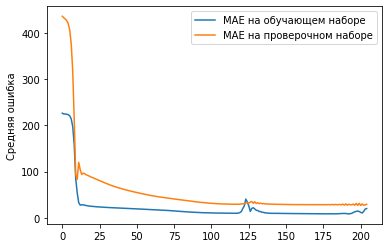

Epoch 1/10
13/13 [==============================] - 0s 12ms/step - loss: 665.9739 - mae: 20.8157 - val_loss: 1278.6464 - val_mae: 27.2993
Epoch 2/10
13/13 [==============================] - 0s 13ms/step - loss: 326.5566 - mae: 15.6891 - val_loss: 1270.1516 - val_mae: 28.9316
Epoch 3/10
13/13 [==============================] - 0s 13ms/step - loss: 383.4703 - mae: 15.6688 - val_loss: 1440.6558 - val_mae: 28.3541
Epoch 4/10
13/13 [==============================] - 0s 13ms/step - loss: 838.3562 - mae: 26.3510 - val_loss: 1272.8009 - val_mae: 29.4158
Epoch 5/10
13/13 [==============================] - 0s 14ms/step - loss: 939.8565 - mae: 25.9893 - val_loss: 1319.4961 - val_mae: 27.8611
Epoch 6/10
13/13 [==============================] - 0s 14ms/step - loss: 945.6669 - mae: 24.7192 - val_loss: 1258.2205 - val_mae: 28.3289
Epoch 1/10
13/13 [==============================] - 0s 14ms/step - loss: 333.5084 - mae: 15.4603 - val_loss: 1306.0272 - val_mae: 28.0889
Epoch 2/10
13/13 [================

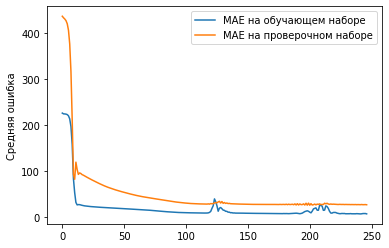

In [27]:
for iteration in range(num_iterations):
  history_1 = model_1.fit(dataset_train,
                      epochs=epochs,
                      validation_data=dataset_val,
                      callbacks=[early_stop])

  hist_val_1.extend(history_1.history['val_mae'][:])
  hist_train_1.extend(history_1.history['mae'][:])

  if (iteration + 1) % 5 == 0:
    plt.plot(hist_train_1, 
            label='MAE на обучающем наборе')
    plt.plot(hist_val_1, 
            label='MAE на проверочном наборе')

    plt.ylabel('Средняя ошибка')
    plt.legend()
    plt.show()

Производим проверку результатов:

In [28]:
pred_1 = model_1.predict(dataset_train).flatten()
pred_val_1 = model_1.predict(dataset_val).flatten()

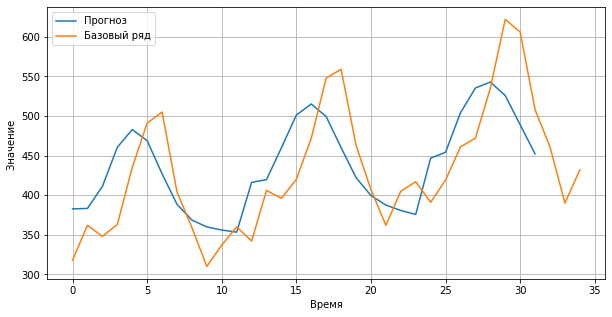

In [29]:
start = 0
step = 50
plt.figure(figsize=(10, 5))
plt.grid('on')
plt.plot(pred_val_1[future + start: future + start + step], 
         label='Прогноз')
plt.plot(y_val.flatten()[start: start+step], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение ')

plt.legend()
plt.show()

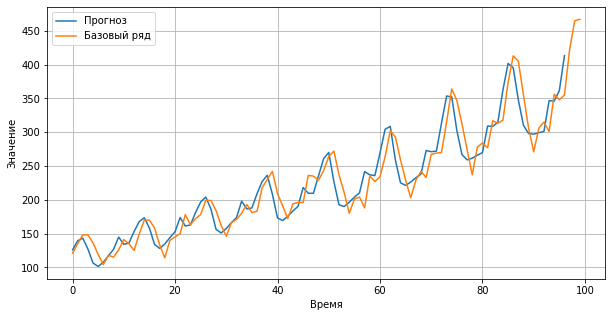

In [30]:
start = 0

plt.figure(figsize=(10, 5))
plt.grid('on')
plt.plot(pred_1[future + start: future + train_size], 
         label='Прогноз')
plt.plot(y_train.flatten()[start: train_size], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение')
plt.legend()
plt.show()

In [31]:
train_loss_1, train_m_1 = model_1.evaluate(dataset_train)
test_loss_1, test_m_1 = model_1.evaluate(dataset_val)
print(f'train_loss: {train_loss_1}, train_m: {train_m_1}')
print(f'test_loss: {test_loss_1}, test_m: {test_m_1}')

model.append('SimpleRNN')
train_m.append(round(train_m_1,2))
test_m.append(round(test_m_1,2))

5/5 [==============================] - 0s 3ms/step - loss: 1147.5623 - mae: 27.5385
train_loss: 92.84912109375, train_m: 7.537648677825928
test_loss: 1147.562255859375, test_m: 27.538522720336914


### LSTM

In [32]:
early_stop = EarlyStopping(monitor='val_mae', patience=5)

model_2 = Sequential()

model_2.add(LSTM(32, input_shape=(inputs.shape[1], inputs.shape[2]),
               return_sequences=True))
model_2.add(LSTM(32, return_sequences=True))
model_2.add(Conv1D(64, 3, activation='linear'))
model_2.add(Conv1D(64, 1, activation='linear'))
model_2.add(Flatten())
model_2.add(Dense(3, activation='linear'))
model_2.add(Dense(1, activation='linear'))

model_2.compile(loss='mse', optimizer='adam', metrics=['mae'])
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 3, 32)             4480      
_________________________________________________________________
lstm_1 (LSTM)                (None, 3, 32)             8320      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1, 64)             6208      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1, 64)             4160      
_________________________________________________________________
flatten_1 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 195       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [33]:
history_2 = model_2.fit(dataset_train,
                    epochs=epochs,
                    validation_data=dataset_val,
                    callbacks=[early_stop])

Epoch 1/10
13/13 [==============================] - 4s 63ms/step - loss: 56643.4805 - mae: 225.6060 - val_loss: 193047.2812 - val_mae: 432.0490
Epoch 2/10
13/13 [==============================] - 0s 13ms/step - loss: 56300.3984 - mae: 224.8730 - val_loss: 192046.5938 - val_mae: 430.8988
Epoch 3/10
13/13 [==============================] - 0s 13ms/step - loss: 55327.9375 - mae: 222.8711 - val_loss: 188712.4375 - val_mae: 427.0499
Epoch 4/10
13/13 [==============================] - 0s 13ms/step - loss: 51972.3281 - mae: 215.8696 - val_loss: 176533.5781 - val_mae: 412.7142
Epoch 5/10
13/13 [==============================] - 0s 14ms/step - loss: 40965.0391 - mae: 191.3067 - val_loss: 134757.7031 - val_mae: 359.3637
Epoch 6/10
13/13 [==============================] - 0s 14ms/step - loss: 14310.6484 - mae: 111.0395 - val_loss: 38343.8633 - val_mae: 185.0527
Epoch 7/10
13/13 [==============================] - 0s 14ms/step - loss: 3296.5073 - mae: 46.8486 - val_loss: 5428.2642 - val_mae: 55.665

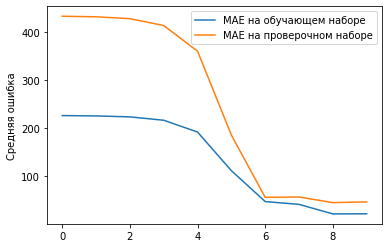

In [34]:
plt.plot(history_2.history['mae'][:], 
         label='MAE на обучающем наборе')
plt.plot(history_2.history['val_mae'][:], 
         label='MAE на проверочном наборе')

plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()
     

In [35]:
hist_val_2 = history_2.history['val_mae']
hist_train_2 = history_2.history['mae']

In [36]:
num_iterations = 25

Epoch 1/10
13/13 [==============================] - 0s 13ms/step - loss: 685.3820 - mae: 20.5193 - val_loss: 3795.0010 - val_mae: 45.3537
Epoch 2/10
13/13 [==============================] - 0s 13ms/step - loss: 670.8044 - mae: 20.2671 - val_loss: 3634.6865 - val_mae: 44.8266
Epoch 3/10
13/13 [==============================] - 0s 13ms/step - loss: 655.6773 - mae: 19.8415 - val_loss: 3684.2993 - val_mae: 44.7209
Epoch 4/10
13/13 [==============================] - 0s 13ms/step - loss: 652.2340 - mae: 19.8418 - val_loss: 3607.0068 - val_mae: 44.3905
Epoch 5/10
13/13 [==============================] - 0s 13ms/step - loss: 649.3240 - mae: 19.7831 - val_loss: 3585.0837 - val_mae: 44.2765
Epoch 6/10
13/13 [==============================] - 0s 13ms/step - loss: 646.4061 - mae: 19.7406 - val_loss: 3553.5444 - val_mae: 44.1311
Epoch 7/10
13/13 [==============================] - 0s 13ms/step - loss: 643.6041 - mae: 19.6915 - val_loss: 3527.8867 - val_mae: 44.0060
Epoch 8/10
13/13 [================

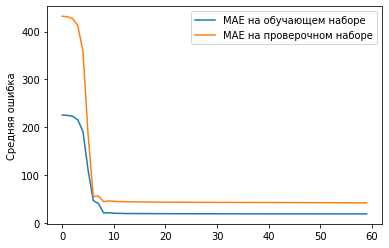

Epoch 1/10
13/13 [==============================] - 0s 13ms/step - loss: 588.3801 - mae: 19.0229 - val_loss: 3043.0591 - val_mae: 42.1339
Epoch 2/10
13/13 [==============================] - 0s 13ms/step - loss: 587.2613 - mae: 19.0099 - val_loss: 3033.0691 - val_mae: 42.0883
Epoch 3/10
13/13 [==============================] - 0s 17ms/step - loss: 586.1196 - mae: 18.9962 - val_loss: 3022.9878 - val_mae: 42.0412
Epoch 4/10
13/13 [==============================] - 0s 13ms/step - loss: 584.9532 - mae: 18.9822 - val_loss: 3012.8101 - val_mae: 41.9926
Epoch 5/10
13/13 [==============================] - 0s 13ms/step - loss: 583.7594 - mae: 18.9676 - val_loss: 3002.5330 - val_mae: 41.9424
Epoch 6/10
13/13 [==============================] - 0s 17ms/step - loss: 582.5364 - mae: 18.9521 - val_loss: 2992.1521 - val_mae: 41.8905
Epoch 7/10
13/13 [==============================] - 0s 13ms/step - loss: 581.2811 - mae: 18.9356 - val_loss: 2981.6638 - val_mae: 41.8368
Epoch 8/10
13/13 [================

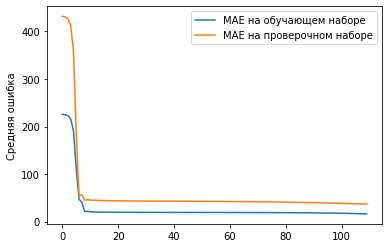

Epoch 1/10
13/13 [==============================] - 0s 13ms/step - loss: 407.5056 - mae: 15.8260 - val_loss: 2146.8020 - val_mae: 36.7772
Epoch 2/10
13/13 [==============================] - 0s 13ms/step - loss: 397.1367 - mae: 15.6131 - val_loss: 2105.1184 - val_mae: 36.5772
Epoch 3/10
13/13 [==============================] - 0s 13ms/step - loss: 386.3099 - mae: 15.3889 - val_loss: 2061.3696 - val_mae: 36.3481
Epoch 4/10
13/13 [==============================] - 0s 13ms/step - loss: 375.0425 - mae: 15.1731 - val_loss: 2015.5275 - val_mae: 36.0876
Epoch 5/10
13/13 [==============================] - 0s 13ms/step - loss: 363.3621 - mae: 14.9652 - val_loss: 1967.5870 - val_mae: 35.7933
Epoch 6/10
13/13 [==============================] - 0s 13ms/step - loss: 351.3078 - mae: 14.7453 - val_loss: 1917.5813 - val_mae: 35.4631
Epoch 7/10
13/13 [==============================] - 0s 13ms/step - loss: 338.9301 - mae: 14.5142 - val_loss: 1865.5891 - val_mae: 35.0950
Epoch 8/10
13/13 [================

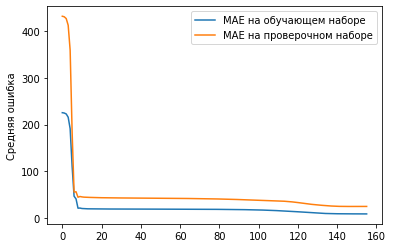

Epoch 1/10
13/13 [==============================] - 0s 13ms/step - loss: 134.9678 - mae: 8.9133 - val_loss: 822.5222 - val_mae: 24.9682
Epoch 2/10
13/13 [==============================] - 0s 13ms/step - loss: 134.5742 - mae: 8.9010 - val_loss: 824.4219 - val_mae: 24.9921
Epoch 3/10
13/13 [==============================] - 0s 14ms/step - loss: 134.1949 - mae: 8.8889 - val_loss: 826.5066 - val_mae: 25.0172
Epoch 4/10
13/13 [==============================] - 0s 13ms/step - loss: 133.8292 - mae: 8.8771 - val_loss: 828.7563 - val_mae: 25.0435
Epoch 5/10
13/13 [==============================] - 0s 13ms/step - loss: 133.4762 - mae: 8.8655 - val_loss: 831.1595 - val_mae: 25.0706
Epoch 6/10
13/13 [==============================] - 0s 13ms/step - loss: 133.1359 - mae: 8.8542 - val_loss: 833.6896 - val_mae: 25.1066
Epoch 1/10
13/13 [==============================] - 0s 13ms/step - loss: 132.8070 - mae: 8.8431 - val_loss: 836.3384 - val_mae: 25.1588
Epoch 2/10
13/13 [==============================

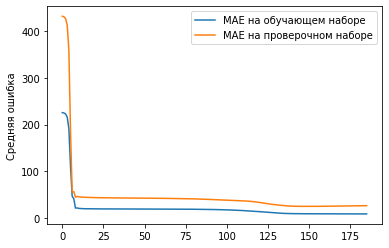

Epoch 1/10
13/13 [==============================] - 0s 19ms/step - loss: 127.3262 - mae: 8.6859 - val_loss: 918.9355 - val_mae: 26.4170
Epoch 2/10
13/13 [==============================] - 0s 17ms/step - loss: 127.1636 - mae: 8.6814 - val_loss: 922.8857 - val_mae: 26.4694
Epoch 3/10
13/13 [==============================] - 0s 13ms/step - loss: 127.0041 - mae: 8.6768 - val_loss: 926.8783 - val_mae: 26.5217
Epoch 4/10
13/13 [==============================] - 0s 13ms/step - loss: 126.8482 - mae: 8.6723 - val_loss: 930.8856 - val_mae: 26.5734
Epoch 5/10
13/13 [==============================] - 0s 12ms/step - loss: 126.6955 - mae: 8.6677 - val_loss: 934.9028 - val_mae: 26.6330
Epoch 6/10
13/13 [==============================] - 0s 16ms/step - loss: 126.5453 - mae: 8.6631 - val_loss: 938.9368 - val_mae: 26.6939
Epoch 1/10
13/13 [==============================] - 0s 13ms/step - loss: 126.3972 - mae: 8.6584 - val_loss: 943.0157 - val_mae: 26.7548
Epoch 2/10
13/13 [==============================

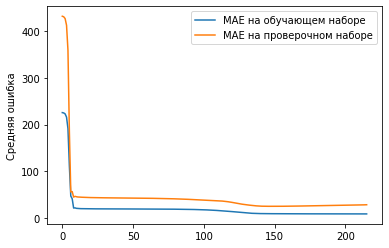

In [37]:
for iteration in range(num_iterations):
  history_2 = model_2.fit(dataset_train,
                      epochs=epochs,
                      validation_data=dataset_val,
                      callbacks=[early_stop])

  hist_val_2.extend(history_2.history['val_mae'][:])
  hist_train_2.extend(history_2.history['mae'][:])

  if (iteration + 1) % 5 == 0:
    plt.plot(hist_train_2, 
            label='MAE на обучающем наборе')
    plt.plot(hist_val_2, 
            label='MAE на проверочном наборе')

    plt.ylabel('Средняя ошибка')
    plt.legend()
    plt.show()

Производим проверку результатов:

In [38]:
pred_2 = model_2.predict(dataset_train).flatten()
pred_val_2 = model_2.predict(dataset_val).flatten()

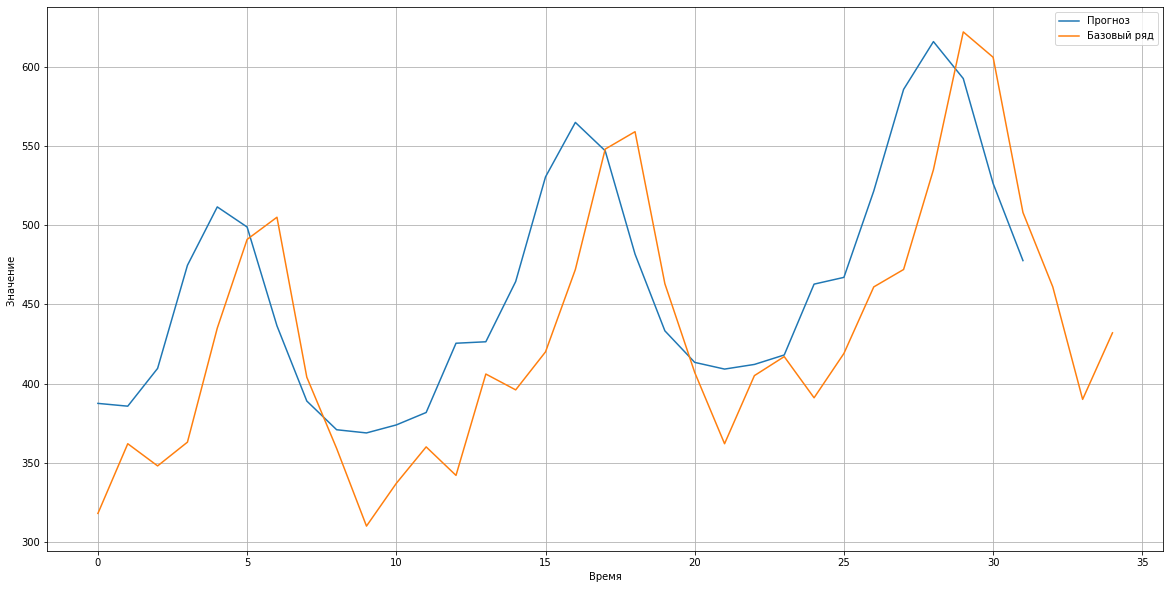

In [39]:
step = 50
plt.figure(figsize=(20, 10))
plt.grid('on')
plt.plot(pred_val_2[future + start: future + start + step], 
         label='Прогноз')
plt.plot(y_val.flatten()[start: start+step], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение ')

plt.legend()
plt.show()

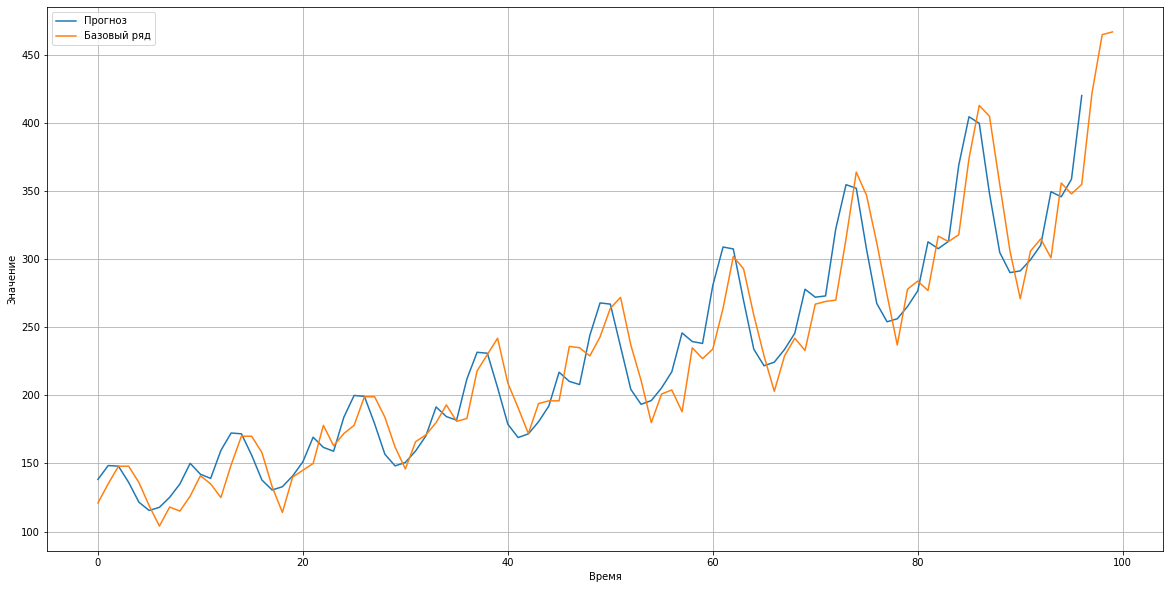

In [40]:
start = 0

plt.figure(figsize=(20, 10))
plt.grid('on')
plt.plot(pred_2[future + start: future + train_size], 
         label='Прогноз')
plt.plot(y_train.flatten()[start: train_size], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение')
plt.legend()
plt.show()

In [41]:
train_loss_2, train_m_2 = model_2.evaluate(dataset_train)
test_loss_2, test_m_2 = model_2.evaluate(dataset_val)
print(f'train_loss: {train_loss_2}, train_m: {train_m_2}')
print(f'test_loss: {test_loss_2}, test_m: {test_m_2}')

model.append('LSTM')
train_m.append(round(train_m_2,2))
test_m.append(round(test_m_2,2))

5/5 [==============================] - 0s 4ms/step - loss: 1055.7015 - mae: 28.2073
train_loss: 100.76192474365234, train_m: 7.758462905883789
test_loss: 1055.7015380859375, test_m: 28.20734977722168


### GRU

In [42]:
# установка ряда метапареметров  для нейронной сети и процесса тренировки
batch_size = 8
hidden_size = 32
num_iterations = 25 
num_epochs = 1
num_preds = 100

In [43]:
model_3 = Sequential()
model_3.add(
    GRU(
        hidden_size,
        return_sequences=True,
        input_shape=(inputs.shape[1], inputs.shape[2]),
        unroll=True
    )
)
model_3.add(Conv1D(64, 3, activation='linear'))
model_3.add(Conv1D(64, 1, activation='linear'))
model_3.add(Flatten())
model_3.add(Dense(3, activation='linear'))
model_3.add(Dense(1, activation='linear'))

model_3.compile(loss='mse', optimizer='adam', metrics=['mae'])
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 3, 32)             3456      
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 1, 64)             6208      
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 1, 64)             4160      
_________________________________________________________________
flatten_2 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 195       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 4         
Total params: 14,023
Trainable params: 14,023
Non-trainable params: 0
__________________________________________________

In [44]:
history_3 = model_3.fit(dataset_train,
                    epochs=epochs,
                    validation_data=dataset_val,
                    callbacks=[early_stop])

Epoch 1/10
13/13 [==============================] - 1s 33ms/step - loss: 56795.7148 - mae: 225.8571 - val_loss: 194036.1406 - val_mae: 433.2168
Epoch 2/10
13/13 [==============================] - 0s 11ms/step - loss: 56366.7656 - mae: 224.9215 - val_loss: 192643.1094 - val_mae: 431.6509
Epoch 3/10
13/13 [==============================] - 0s 12ms/step - loss: 55864.7500 - mae: 224.0289 - val_loss: 190313.2969 - val_mae: 429.0545
Epoch 4/10
13/13 [==============================] - 0s 11ms/step - loss: 54507.9688 - mae: 221.5069 - val_loss: 184201.6562 - val_mae: 422.1781
Epoch 5/10
13/13 [==============================] - 0s 11ms/step - loss: 50495.0781 - mae: 213.6906 - val_loss: 166879.8125 - val_mae: 401.9295
Epoch 6/10
13/13 [==============================] - 0s 11ms/step - loss: 39489.9062 - mae: 189.6202 - val_loss: 122781.7109 - val_mae: 344.2825
Epoch 7/10
13/13 [==============================] - 0s 12ms/step - loss: 17557.1133 - mae: 121.7630 - val_loss: 45495.8242 - val_mae: 20

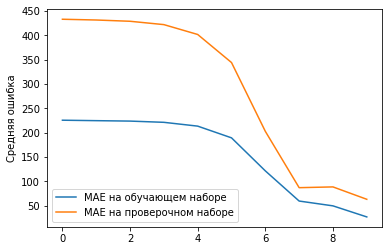

In [45]:
plt.plot(history_3.history['mae'][:], 
         label='MAE на обучающем наборе')
plt.plot(history_3.history['val_mae'][:], 
         label='MAE на проверочном наборе')

plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [46]:
hist_val_3 = history_3.history['val_mae']
hist_train_3 = history_3.history['mae']

Epoch 1/10
13/13 [==============================] - 0s 12ms/step - loss: 882.5382 - mae: 23.6805 - val_loss: 5703.0513 - val_mae: 55.2649
Epoch 2/10
13/13 [==============================] - 0s 12ms/step - loss: 765.1063 - mae: 21.9861 - val_loss: 6325.1157 - val_mae: 58.5648
Epoch 3/10
13/13 [==============================] - 0s 12ms/step - loss: 761.3448 - mae: 22.0174 - val_loss: 5930.6826 - val_mae: 56.4484
Epoch 4/10
13/13 [==============================] - 0s 12ms/step - loss: 755.8589 - mae: 21.8937 - val_loss: 5936.0005 - val_mae: 56.5988
Epoch 5/10
13/13 [==============================] - 0s 11ms/step - loss: 742.0605 - mae: 21.7037 - val_loss: 5895.7734 - val_mae: 56.4515
Epoch 6/10
13/13 [==============================] - 0s 11ms/step - loss: 740.3597 - mae: 21.7112 - val_loss: 5773.0132 - val_mae: 55.7941
Epoch 1/10
13/13 [==============================] - 0s 11ms/step - loss: 733.4279 - mae: 21.5810 - val_loss: 5715.2119 - val_mae: 55.4819
Epoch 2/10
13/13 [================

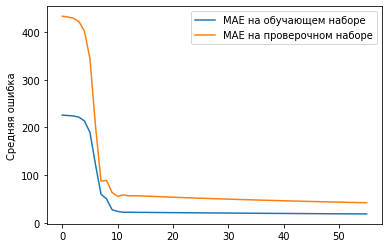

Epoch 1/10
13/13 [==============================] - 0s 11ms/step - loss: 567.4236 - mae: 18.4709 - val_loss: 3450.4124 - val_mae: 41.7891
Epoch 2/10
13/13 [==============================] - 0s 11ms/step - loss: 565.0089 - mae: 18.4390 - val_loss: 3419.3003 - val_mae: 41.5841
Epoch 3/10
13/13 [==============================] - 0s 12ms/step - loss: 562.6785 - mae: 18.4094 - val_loss: 3389.3191 - val_mae: 41.3814
Epoch 4/10
13/13 [==============================] - 0s 11ms/step - loss: 560.4316 - mae: 18.3803 - val_loss: 3360.4482 - val_mae: 41.1863
Epoch 5/10
13/13 [==============================] - 0s 12ms/step - loss: 558.2675 - mae: 18.3514 - val_loss: 3332.6770 - val_mae: 41.0193
Epoch 6/10
13/13 [==============================] - 0s 12ms/step - loss: 556.1851 - mae: 18.3226 - val_loss: 3305.9766 - val_mae: 40.8545
Epoch 7/10
13/13 [==============================] - 0s 11ms/step - loss: 554.1832 - mae: 18.2940 - val_loss: 3280.3313 - val_mae: 40.6929
Epoch 8/10
13/13 [================

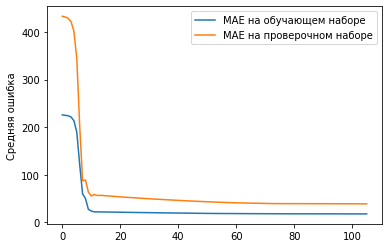

Epoch 1/10
13/13 [==============================] - 0s 12ms/step - loss: 509.8910 - mae: 17.6322 - val_loss: 2735.3193 - val_mae: 38.7443
Epoch 2/10
13/13 [==============================] - 0s 11ms/step - loss: 509.0880 - mae: 17.6188 - val_loss: 2727.6597 - val_mae: 38.7130
Epoch 3/10
13/13 [==============================] - 0s 11ms/step - loss: 508.2661 - mae: 17.6049 - val_loss: 2719.9895 - val_mae: 38.6806
Epoch 4/10
13/13 [==============================] - 0s 11ms/step - loss: 507.4243 - mae: 17.5904 - val_loss: 2712.2964 - val_mae: 38.6472
Epoch 5/10
13/13 [==============================] - 0s 12ms/step - loss: 506.5600 - mae: 17.5754 - val_loss: 2704.5757 - val_mae: 38.6125
Epoch 6/10
13/13 [==============================] - 0s 12ms/step - loss: 505.6715 - mae: 17.5597 - val_loss: 2696.8184 - val_mae: 38.5767
Epoch 7/10
13/13 [==============================] - 0s 12ms/step - loss: 504.7573 - mae: 17.5433 - val_loss: 2689.0188 - val_mae: 38.5396
Epoch 8/10
13/13 [================

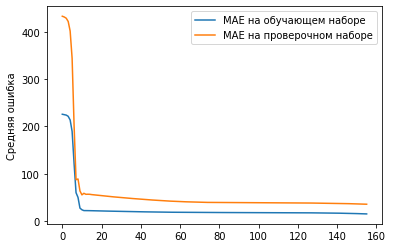

Epoch 1/10
13/13 [==============================] - 0s 15ms/step - loss: 364.4422 - mae: 14.7784 - val_loss: 2031.0507 - val_mae: 35.2631
Epoch 2/10
13/13 [==============================] - 0s 12ms/step - loss: 355.6754 - mae: 14.6105 - val_loss: 1996.0061 - val_mae: 35.0545
Epoch 3/10
13/13 [==============================] - 0s 13ms/step - loss: 346.5056 - mae: 14.4328 - val_loss: 1959.4351 - val_mae: 34.8259
Epoch 4/10
13/13 [==============================] - 0s 12ms/step - loss: 336.9632 - mae: 14.2487 - val_loss: 1921.2665 - val_mae: 34.5722
Epoch 5/10
13/13 [==============================] - 0s 12ms/step - loss: 327.0720 - mae: 14.0534 - val_loss: 1881.4561 - val_mae: 34.3105
Epoch 6/10
13/13 [==============================] - 0s 12ms/step - loss: 316.8636 - mae: 13.8461 - val_loss: 1840.4136 - val_mae: 34.0352
Epoch 7/10
13/13 [==============================] - 0s 12ms/step - loss: 306.3996 - mae: 13.6243 - val_loss: 1798.0157 - val_mae: 33.7306
Epoch 8/10
13/13 [================

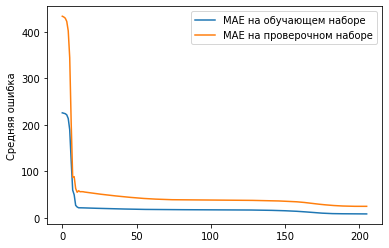

Epoch 1/10
13/13 [==============================] - 0s 12ms/step - loss: 125.1469 - mae: 8.7955 - val_loss: 911.6491 - val_mae: 25.1312
Epoch 2/10
13/13 [==============================] - 0s 23ms/step - loss: 124.6572 - mae: 8.7757 - val_loss: 911.9100 - val_mae: 25.1470
Epoch 3/10
13/13 [==============================] - 0s 12ms/step - loss: 124.1757 - mae: 8.7554 - val_loss: 912.3591 - val_mae: 25.1632
Epoch 4/10
13/13 [==============================] - 0s 12ms/step - loss: 123.7023 - mae: 8.7348 - val_loss: 912.9854 - val_mae: 25.1797
Epoch 5/10
13/13 [==============================] - 0s 13ms/step - loss: 123.2372 - mae: 8.7141 - val_loss: 913.7726 - val_mae: 25.1964
Epoch 6/10
13/13 [==============================] - 0s 11ms/step - loss: 122.7806 - mae: 8.6937 - val_loss: 914.7186 - val_mae: 25.2133
Epoch 1/10
13/13 [==============================] - 0s 12ms/step - loss: 122.3321 - mae: 8.6731 - val_loss: 915.8004 - val_mae: 25.2304
Epoch 2/10
13/13 [==============================

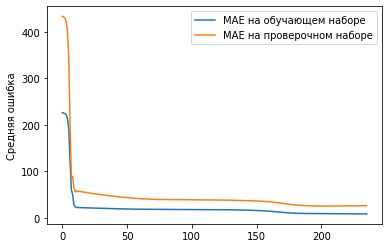

In [47]:
for iteration in range(num_iterations):
  history_3 = model_3.fit(dataset_train,
                      epochs=epochs,
                      validation_data=dataset_val,
                      callbacks=[early_stop])

  hist_val_3.extend(history_3.history['val_mae'][:])
  hist_train_3.extend(history_3.history['mae'][:])

  if (iteration + 1) % 5 == 0:
    plt.plot(hist_train_3, 
            label='MAE на обучающем наборе')
    plt.plot(hist_val_3, 
            label='MAE на проверочном наборе')

    plt.ylabel('Средняя ошибка')
    plt.legend()
    plt.show()

In [48]:
pred_3 = model_3.predict(dataset_train).flatten()
pred_val_3 = model_3.predict(dataset_val).flatten()

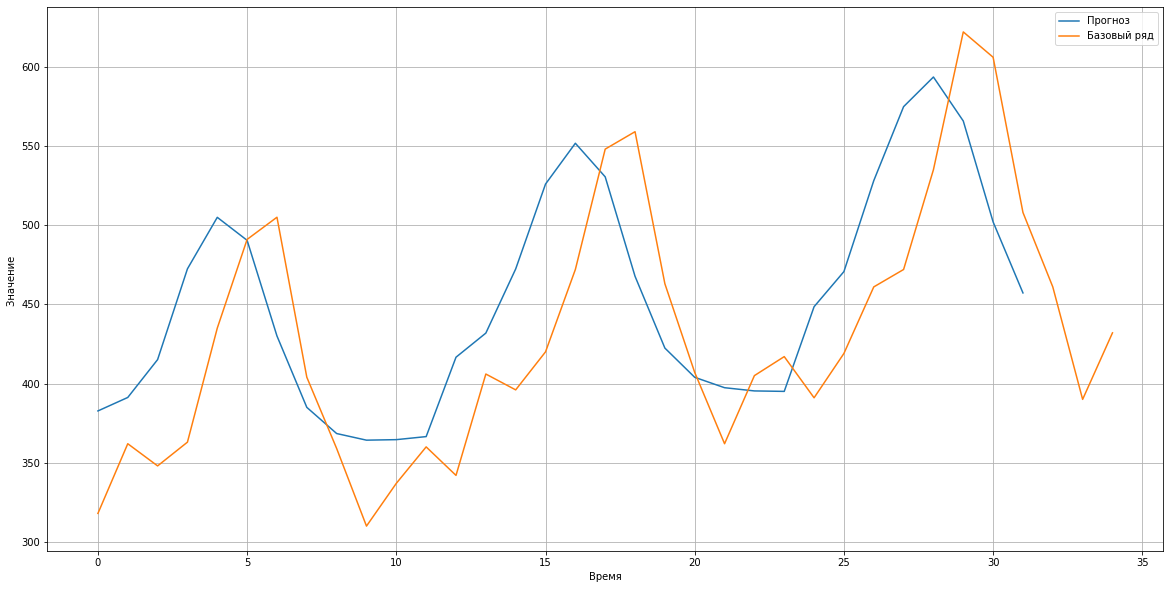

In [49]:
start = 0
step = 50
plt.figure(figsize=(20, 10))
plt.grid('on')
plt.plot(pred_val_3[future + start: future + start + step], 
         label='Прогноз')
plt.plot(y_val.flatten()[start: start+step], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение ')

plt.legend()
plt.show()

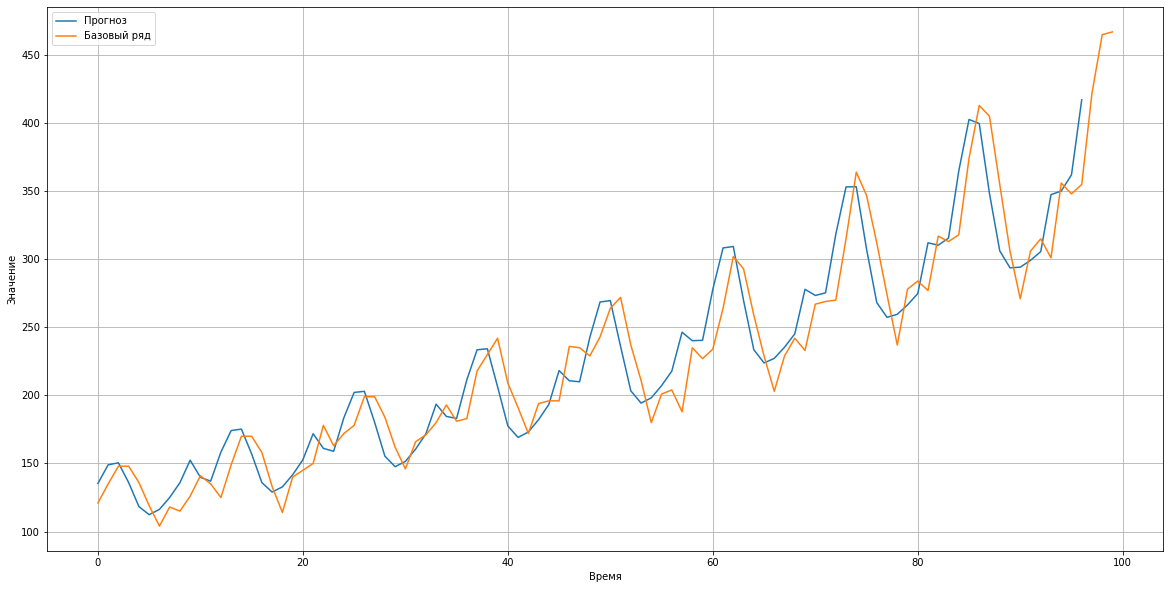

In [50]:
start = 0

plt.figure(figsize=(20, 10))
plt.grid('on')
plt.plot(pred_3[future + start: future + train_size], 
         label='Прогноз')
plt.plot(y_train.flatten()[start: train_size], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение')
plt.legend()
plt.show()

In [51]:
train_loss_3, train_m_3 = model_3.evaluate(dataset_train)
test_loss_3, test_m_3 = model_3.evaluate(dataset_val)
print(f'train_loss: {train_loss_3}, train_m: {train_m_3}')
print(f'test_loss: {test_loss_3}, test_m: {test_m_3}')

model.append('GRU')
train_m.append(round(train_m_3,2))
test_m.append(round(test_m_3,2))

5/5 [==============================] - 0s 3ms/step - loss: 966.6008 - mae: 26.0931
train_loss: 98.15254211425781, train_m: 7.713857173919678
test_loss: 966.6007690429688, test_m: 26.09309196472168


In [52]:
results['model'] = model
results['train_m'] = train_m
results['test_m'] = test_m

In [53]:
results

,model,train_m,test_m
0,SimpleRNN,7.54,27.54
1,LSTM,7.76,28.21
2,GRU,7.71,26.09


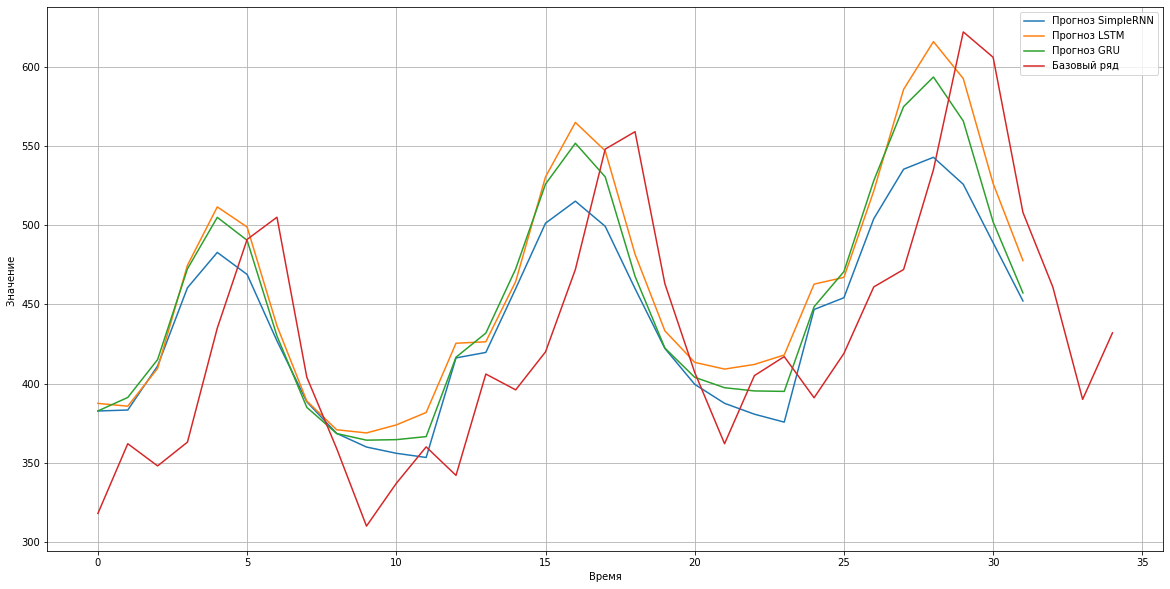

In [54]:
start = 0
step = 50
plt.figure(figsize=(20, 10))
plt.grid('on')
plt.plot(pred_val_1[future + start: future + start + step], 
         label='Прогноз SimpleRNN')
plt.plot(pred_val_2[future + start: future + start + step], 
         label='Прогноз LSTM')
plt.plot(pred_val_3[future + start: future + start + step], 
         label='Прогноз GRU')
plt.plot(y_val.flatten()[start: start+step], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение ')

plt.legend()
plt.show()

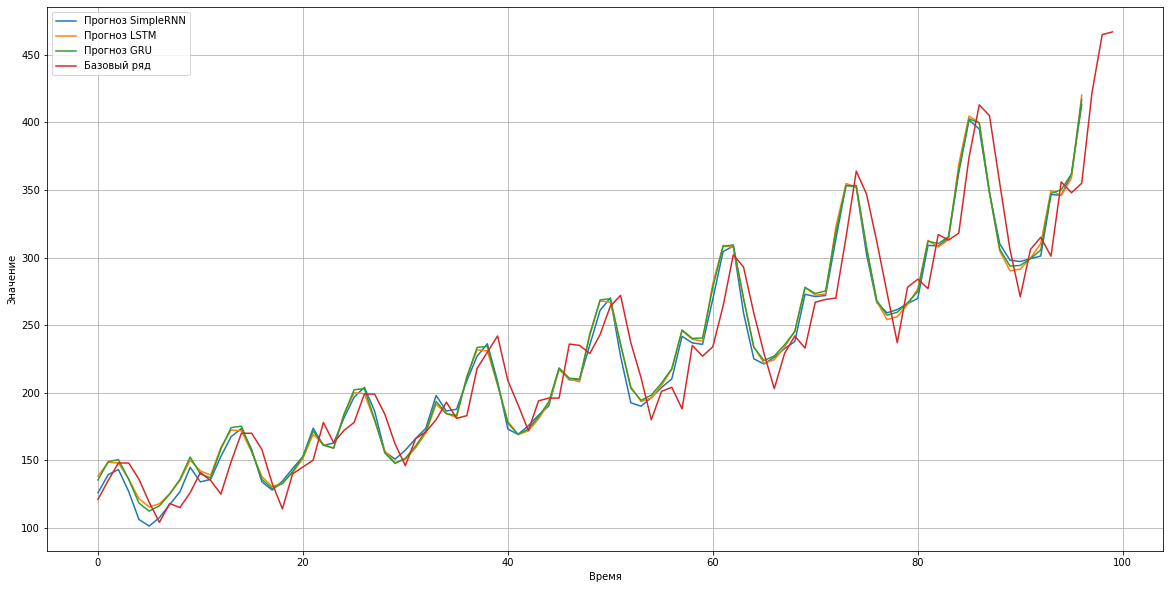

In [55]:
start = 0

plt.figure(figsize=(20, 10))
plt.grid('on')
plt.plot(pred_1[future + start: future + train_size], 
         label='Прогноз SimpleRNN')
plt.plot(pred_2[future + start: future + train_size], 
         label='Прогноз LSTM')
plt.plot(pred_3[future + start: future + train_size], 
         label='Прогноз GRU')
plt.plot(y_train.flatten()[start: train_size], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение')
plt.legend()
plt.show()

### Выводы:

* чем больше итераций - тем выше качество (25 и правда хватает)
* для данного датасета лучше справился GRU, хотя LSTM сравним с ним по качеству